In [18]:
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ipywidgets import FileUpload, Output
from IPython.display import display

# paths and parameters
TRAIN_DIR = "DATASET/TRAIN/"
TEST_DIR = "DATASET/TEST/"
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 16
EPOCHS_INITIAL = 45
EPOCHS_FINE_TUNE = 20
MODEL_DIR = "./model_uray"
CHECKPOINT_FILE = "model_checkpoint_best_final_3.keras"
CHECKPOINT_PATH = os.path.join(MODEL_DIR, CHECKPOINT_FILE)
LEARNING_RATE_FINE_TUNE = 1e-5

# Create model directory if not exists
os.makedirs(MODEL_DIR, exist_ok=True)



In [19]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode="nearest",
)

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle="True"
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)



Found 688 images belonging to 26 classes.
Found 159 images belonging to 26 classes.
Found 208 images belonging to 26 classes.


In [20]:
from tensorflow.keras.regularizers import l2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation="relu", kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output_layer = Dense(
    train_generator.num_classes,
    activation="softmax",
    kernel_regularizer=l2(1e-4),
)(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Freeze some of the deeper base model layers
for layer in base_model.layers[:120]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

# Load checkpoint if exists
if os.path.exists(CHECKPOINT_PATH):
    print("Checkpoint found. Loading model...")
    model = tf.keras.models.load_model(CHECKPOINT_PATH)
else:
    print("No checkpoint found. Training model from scratch...")



No checkpoint found. Training model from scratch...


In [21]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8),
    ModelCheckpoint(CHECKPOINT_PATH, monitor="val_accuracy", save_best_only=True, save_weights_only=False, verbose=1),
]



In [22]:
history = model.fit(
    train_generator,
    epochs=EPOCHS_INITIAL,
    validation_data=validation_generator,
    callbacks=callbacks,
)

# Fine-tuning
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE_FINE_TUNE, weight_decay=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history_fine_tune = model.fit(
    train_generator,
    epochs=EPOCHS_FINE_TUNE,
    validation_data=validation_generator,
    callbacks=callbacks,
)



Epoch 1/45
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.0675 - loss: 4.1210
Epoch 1: val_accuracy improved from -inf to 0.22013, saving model to ./model_uray/model_checkpoint_best_final_3.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - accuracy: 0.0688 - loss: 4.1114 - val_accuracy: 0.2201 - val_loss: 2.8863 - learning_rate: 1.0000e-04
Epoch 2/45
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3585 - loss: 2.4869
Epoch 2: val_accuracy improved from 0.22013 to 0.29560, saving model to ./model_uray/model_checkpoint_best_final_3.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.3590 - loss: 2.4840 - val_accuracy: 0.2956 - val_loss: 2.5083 - learning_rate: 1.0000e-04
Epoch 3/45
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5387 - loss: 1.6963
Epoch 3: val_accuracy improved from 0.29560 to 0.35849, saving model to ./model_uray/model_checkpoint_best_final_3.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.5387 - loss: 1.6959 - val_accuracy: 0.3

In [23]:
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss:.3f}, Validation Accuracy: {validation_accuracy:.2%}")

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2%}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8232 - loss: 0.9429
Validation Loss: 1.192, Validation Accuracy: 77.99%
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8412 - loss: 0.7121
Test Loss: 0.736, Test Accuracy: 83.17%


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


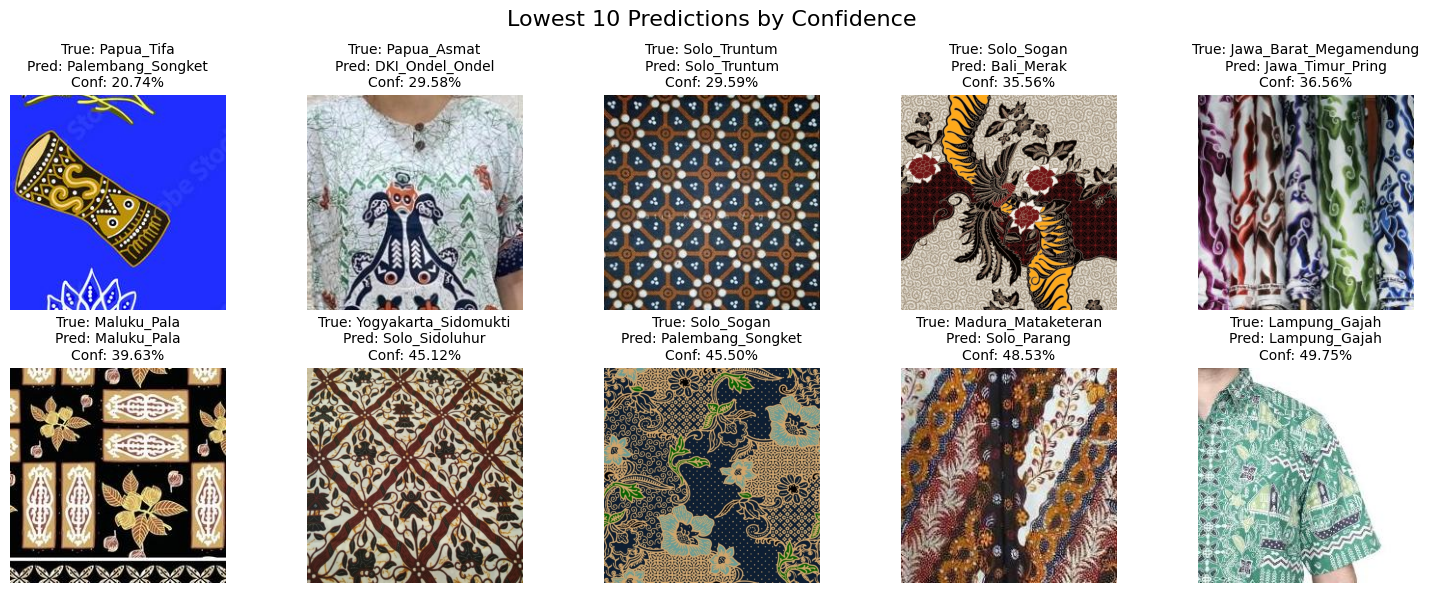

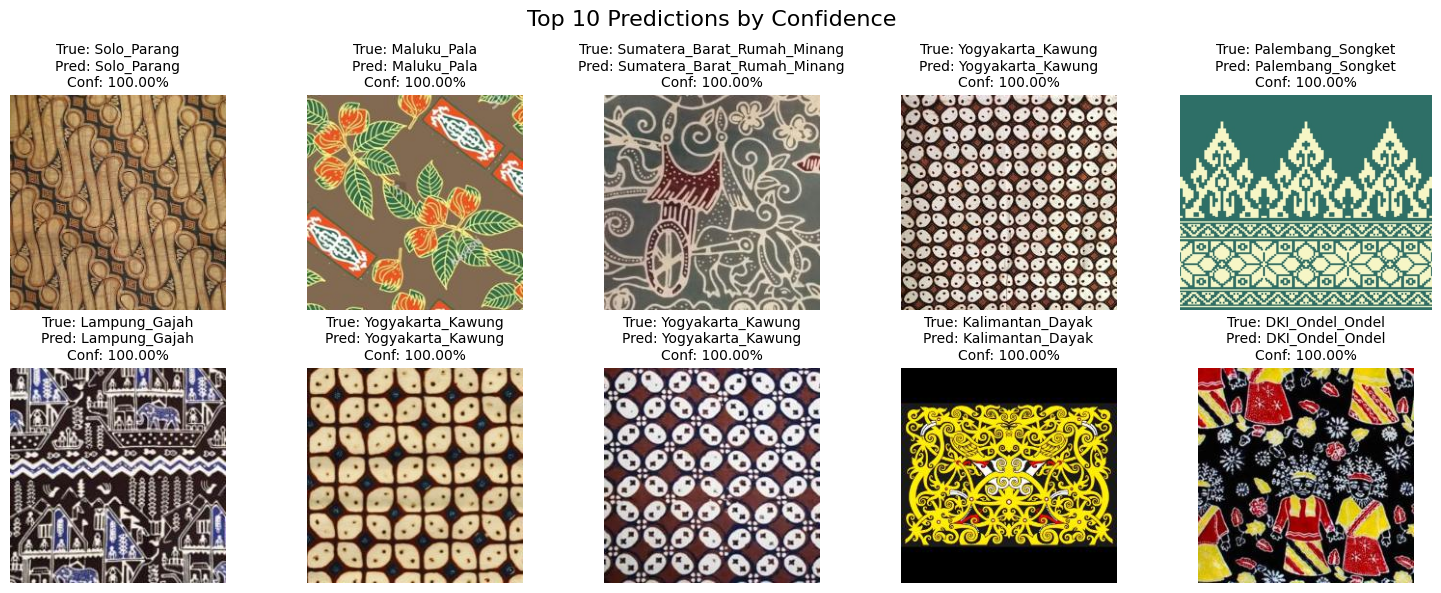

In [24]:
predictions = model.predict(test_generator)
class_labels = list(test_generator.class_indices.keys())
true_indices = test_generator.classes
predicted_indices = np.argmax(predictions, axis=1)
prediction_confidences = np.max(predictions, axis=1)

# Visualization function
def visualize_predictions(indices, title, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    for i, idx in enumerate(indices):
        img_path = test_generator.filepaths[idx]
        img = plt.imread(img_path)
        true_label = class_labels[true_indices[idx]]
        predicted_label = class_labels[predicted_indices[idx]]
        confidence = prediction_confidences[idx] * 100

        ax = axes[i // cols, i % cols]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}%", fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Lowest and highest confidence predictions
low_conf_indices = np.argsort(prediction_confidences)[:10]
high_conf_indices = np.argsort(prediction_confidences)[-10:][::-1]

visualize_predictions(low_conf_indices, "Lowest 10 Predictions by Confidence")
visualize_predictions(high_conf_indices, "Top 10 Predictions by Confidence")



In [25]:
def evaluate_by_folder(generator, predictions):
    folder_results = defaultdict(lambda: {"correct": 0, "total": 0})
    predicted_indices = np.argmax(predictions, axis=1)

    for filepath, true_idx, pred_idx in zip(generator.filepaths, generator.classes, predicted_indices):
        folder = os.path.basename(os.path.dirname(filepath))
        folder_results[folder]["total"] += 1
        if true_idx == pred_idx:
            folder_results[folder]["correct"] += 1

    return {folder: f"{result['correct']}/{result['total']}" for folder, result in folder_results.items()}

folder_results = evaluate_by_folder(test_generator, predictions)
print("Folder-wise Evaluation Results:")
for folder, result in folder_results.items():
    print(f"{folder}: {result}")



Folder-wise Evaluation Results:
Aceh_Pintu_Aceh: 6/8
Bali_Barong: 7/8
Bali_Merak: 8/8
DKI_Ondel_Ondel: 7/8
Jawa_Barat_Megamendung: 6/8
Jawa_Tengah_Batik_Lasem: 6/8
Jawa_Timur_Pring: 7/8
Kalimantan_Barat_Insang: 6/8
Kalimantan_Dayak: 8/8
Lampung_Gajah: 6/8
Madura_Mataketeran: 7/8
Maluku_Pala: 8/8
NTB_Lumbung: 8/8
Palembang_Songket: 8/8
Papua_Asmat: 4/8
Papua_Cendrawasih: 6/8
Papua_Tifa: 7/8
Solo_Parang: 8/8
Solo_Sidoluhur: 5/8
Solo_Sogan: 6/8
Solo_Truntum: 7/8
Sulawesi_Selatan_Lontara: 5/8
Sumatera_Barat_Rumah_Minang: 6/8
Sumatera_Utara_Boraspati: 8/8
Yogyakarta_Kawung: 8/8
Yogyakarta_Sidomukti: 5/8


In [26]:
output = Output()
upload_widget = FileUpload(accept="image/*", multiple=False)
class_labels = list(test_generator.class_indices.keys())

def handle_upload(change):
    output.clear_output()
    with output:
        # Check if a file is uploaded
        if not upload_widget.value:
            print("Please upload an image file.")
            return
        
        # Access uploaded file content
        try:
            # If upload_widget.value is a dict
            if isinstance(upload_widget.value, dict):
                file = list(upload_widget.value.values())[0]
            # If upload_widget.value is a list or tuple
            elif isinstance(upload_widget.value, (list, tuple)):
                file = upload_widget.value[0]
            else:
                print("Unsupported upload format.")
                return

            temp_path = "./uploaded_image.jpg"
            
            # Save the file to a temporary location
            with open(temp_path, "wb") as f:
                f.write(file["content"])
            
            # Load the model from the checkpoint
            if os.path.exists(CHECKPOINT_PATH):
                print("Loading model from checkpoint...")
                loaded_model = tf.keras.models.load_model(CHECKPOINT_PATH)
            else:
                print("No checkpoint found. Ensure the model is trained and checkpoint exists.")
                return
            
            # Load and preprocess the uploaded image
            img = load_img(temp_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
            
            # Make prediction
            preds = loaded_model.predict(img_array)
            predicted_idx = np.argmax(preds)
            confidence = preds[0][predicted_idx] * 100
            predicted_label = class_labels[predicted_idx]
            
            # Display the uploaded image with prediction result
            plt.figure(figsize=(6, 6))
            img_display = plt.imread(temp_path)
            plt.imshow(img_display)
            plt.axis("off")
            plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence:.2f}%", fontsize=14)
            plt.show()
        
        except Exception as e:
            # Catch and display any errors
            print(f"Error during processing: {str(e)}")

# Observe the upload widget
upload_widget.observe(handle_upload, names="value")
display(upload_widget, output)


FileUpload(value=(), accept='image/*', description='Upload')

Output()

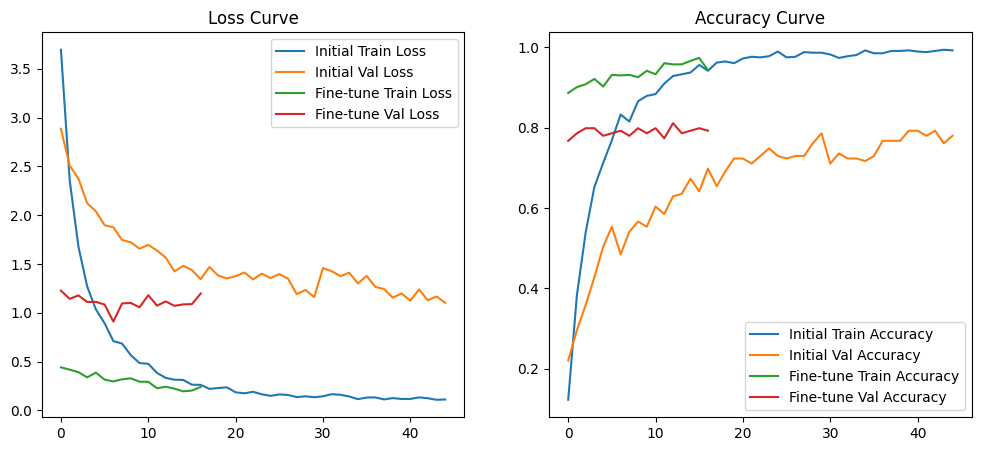

In [27]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Initial Train Loss")
plt.plot(history.history["val_loss"], label="Initial Val Loss")
plt.plot(history_fine_tune.history["loss"], label="Fine-tune Train Loss")
plt.plot(history_fine_tune.history["val_loss"], label="Fine-tune Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Initial Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Initial Val Accuracy")
plt.plot(history_fine_tune.history["accuracy"], label="Fine-tune Train Accuracy")
plt.plot(history_fine_tune.history["val_accuracy"], label="Fine-tune Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()



In [28]:
# # Path to the .keras model
# keras_model_path = CHECKPOINT_PATH

# # Path to save the .h5 model
# h5_model_path = os.path.join(MODEL_DIR, "model_checkpoint_best_3_h.h5")

# # Step 1: Load the .keras model
# model = tf.keras.models.load_model(keras_model_path)
# print("Model loaded successfully.")

# # Step 2: Save the model in .h5 format
# model.save(h5_model_path, save_format="h5")
# print(f"Model saved successfully to {h5_model_path}.")


In [29]:
# # Save the model architecture to JSON
# model_json = model.to_json()
# with open(os.path.join(MODEL_DIR, 'model_architecture.json'), 'w') as json_file:
#     json_file.write(model_json)
# print("Model architecture saved successfully.")
